In [68]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [69]:
import math
import time

import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, svd, qr
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.preprocessing import StandardScaler

In [70]:
def diffsnorm(data, reconstruct):
    return norm(data-reconstruct)/norm(data+reconstruct)


In [71]:
def eig_error(eig_approx, eig):
    corr = np.linalg.norm(eig_approx-eig)
    corr = np.inner(eig_approx, eig)
    return corr


In [72]:
def subspace_error(U_approx, U):
    n_components = U.shape[1]
    A = U_approx.T.dot(U)
    B = U_approx.dot(U_approx.T)

    err = np.sqrt(n_components+np.trace(B.dot(B)) - 2 * np.trace(A.dot(A.T)))

    frob = np.linalg.norm(U-U_approx, ord='fro')

    return err/np.sqrt(n_components )


In [73]:
def modify_loading(loading, component):
    n_sample, n_component = loading.shape

    minimum = np.amin(loading, axis=0)
    maximum = np.amax(loading, axis=0)

    idx = []

    for i in range(n_sample):
        check = np.where((loading[i, :] == minimum) | (loading[i, :] == maximum), True, False)
        if True in check:
            idx.append(i)

    src_loading = loading[np.array(idx)]
    src_data = src_loading @ component

    return src_data


In [74]:
def process_partition(data, n_components, n_part):
    """
    Split data into four partitions and apply PCA on each partition
    """
    partition = []
    
    m = int(np.sqrt(n_part))
    n = int(np.sqrt(n_part))
    k = int(data.shape[0]/m)
    l = int(data.shape[1]/n)
        
    for i in range(m):
        for j in range(n):
            part = data[i*k:i*k+k, j*l:j*l+l, :, :]
            part_reshape = part.reshape((part.shape[0]*part.shape[1], part.shape[2]*part.shape[3]))
            U, S, V = svd(part_reshape, full_matrices=False)            
            partition.append((U[:, :n_components], S[:n_components], V[:n_components], part_reshape[0]))
    
    return partition


In [75]:
def merge(data, partition, n_components):
    """
    Merge PCA results from partitions
    """
    ipca = IncrementalPCA(n_components=n_components)
    
    for part in partition:
        reconstruct = modify_loading(part[0]*part[1], part[2])
        ipca.partial_fit(reconstruct)
    
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2] * data.shape[3]))
    data_transformed = ipca.fit_transform(data)
    reconstructed_data = ipca.inverse_transform(data_transformed)
    
    return data_transformed, reconstructed_data
        
        

In [76]:
def run_pca(data, n_components=100, noise_factor=None, n_part=4):
        
    sig_dim = int(math.sqrt(data.shape[0]))
    nav_dim = int(math.sqrt(data.shape[1]))
    
    assert (sig_dim ** 2) == data.shape[0]
    assert (nav_dim ** 2) == data.shape[1]
    
    new_data = data.copy()
    
    if noise_factor:
        noise = np.random.normal(0, 0.1, size=(new_data.shape[0], new_data.shape[1])) * noise_factor
        new_data += noise
    
    # reformat data into sig and nav dimension
    new_data = new_data.reshape((sig_dim, sig_dim, nav_dim, nav_dim))
    partition = process_partition(new_data, n_components, n_part)
    data_transformed, reconstructed_data = merge(new_data, partition, n_components)
       
    return data_transformed, reconstructed_data

In [77]:
from collections import Counter

def max_norm(reconstructed_data, benchmark_data):
    diff = np.abs(reconstructed_data - benchmark_data)
    max_idx = np.argmax(diff, axis=0).tolist()
    count = Counter(max_idx)
    
    return count.most_common(1)

In [78]:
def compare_benchmark(data, n_components=100, bool_time=False):
    """
    Compare PCA with standard PCA libraries for benchmarking purpose
    """
    start = time.time()
    
    data_transformed, reconstructed_data = run_pca(data, n_components)
    
    end = time.time()
    
    new_time = end - start

    norm_diff = diffsnorm(reconstructed_data, data)
    
    start = time.time()
    
    assert len(data.shape) == 2
    pca = PCA(n_components=n_components)
    pca.fit(data)
    
    transformed_data = pca.fit_transform(data)
    benchmark_reconstruct = pca.inverse_transform(transformed_data)
    
    end = time.time()
    
    orig_time = end - start

    benchmark_diff = diffsnorm(benchmark_reconstruct, data)
    
    transformed_diff = diffsnorm(np.abs(data_transformed), np.abs(transformed_data))
    
    if bool_time:
        print(f"For the implemented PCA, it took {new_time}s. For standard PCA, it took {orig_time}s")
        return norm_diff, benchmark_diff, transformed_diff, new_time, orig_time
    
    return norm_diff, benchmark_diff, transformed_diff

# data prep

In [79]:
component = ortho_group.rvs(dim=1024)[:100, :]

In [80]:
# standard data generated by 100 components
loading = np.random.rand(1024, 100)
data = loading @ component
np.random.shuffle(data.T)

In [81]:
# random noisy data
noise_data = np.random.rand(1024, 1024)

In [82]:
# A component contained within a single frame
last_component, new_component = component[99], component[:99]
loading = np.random.rand(1024, 99)
single_data = loading @ new_component

In [83]:
# Scale components differently to check if PCA catches them
def scale_data(data, order):
    
    scaler = np.logspace(order, 1, 1024).T
    scaler = scaler.reshape((-1, 1)).T
    np.random.shuffle(scaler.T)
    scaler = np.repeat(scaler, repeats=100, axis=0)
    
    new_component = np.multiply(scaler, component)

    loading = np.random.rand(1024, 100)

    scaled_data = loading @ new_component
    np.random.shuffle(scaled_data.T)
    
    return scaled_data

In [84]:
# Include frames that are pure random noise
def noise_frame(perc):
    new_data = np.random.rand(1024, 100) @ component
    perc_num = int(1024 * perc)
    new_data = new_data[:perc_num]
    random_data = np.random.rand(1024-perc_num, 1024)
    noise_frame_data = np.vstack((new_data, random_data))
    
    return noise_frame_data
    
    

# Data generated using 100 components vs Noisy data (w/ dimension 1024)

In [85]:
for n_component in range(10, 200, 10):
    U, S, V = svd(data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = ((data @ V.T) @ V)
    norm_diff = diffsnorm(reconstructed_data, data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.2511671110746899
norm difference wih 20 components using full batch data: 0.22616758072180929
norm difference wih 30 components using full batch data: 0.20259139416988717
norm difference wih 40 components using full batch data: 0.1798304176609398
norm difference wih 50 components using full batch data: 0.15740122120118244
norm difference wih 60 components using full batch data: 0.13489042110127897
norm difference wih 70 components using full batch data: 0.11205295642041539
norm difference wih 80 components using full batch data: 0.08764821350828601
norm difference wih 90 components using full batch data: 0.05900104589170752
norm difference wih 100 components using full batch data: 5.537259226000777e-16
norm difference wih 110 components using full batch data: 5.615524632615545e-16
norm difference wih 120 components using full batch data: 5.648053841746105e-16
norm difference wih 130 components using full batch data: 5.668141798

In [86]:
for n_component in range(10, 200, 10):
    U, S, V = svd(noise_data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = (noise_data @ V.T) @ V
    norm_diff = diffsnorm(reconstructed_data, noise_data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.2715311501915308
norm difference wih 20 components using full batch data: 0.2654453763644331
norm difference wih 30 components using full batch data: 0.25960454927366344
norm difference wih 40 components using full batch data: 0.25396599158376126
norm difference wih 50 components using full batch data: 0.24851815547164482
norm difference wih 60 components using full batch data: 0.24320035001328863
norm difference wih 70 components using full batch data: 0.23803254279404262
norm difference wih 80 components using full batch data: 0.23300442914206507
norm difference wih 90 components using full batch data: 0.22810244854453102
norm difference wih 100 components using full batch data: 0.22330682432588816
norm difference wih 110 components using full batch data: 0.21861268507098308
norm difference wih 120 components using full batch data: 0.2140107338270407
norm difference wih 130 components using full batch data: 0.2095109334480452

In [87]:
data_transformed, reconstructed_data = run_pca(data, n_components=100)
norm_diff = diffsnorm(reconstructed_data, data)
print(f"norm difference between original and reconstructed data: {norm_diff}")

norm difference between original and reconstructed data: 6.020734123305333e-16


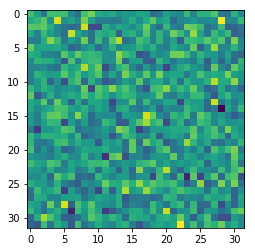

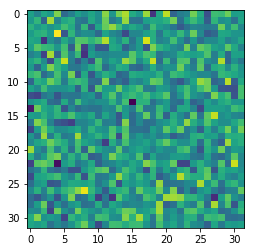

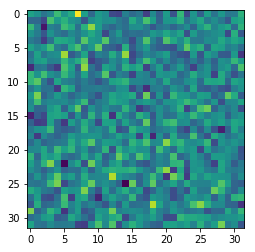

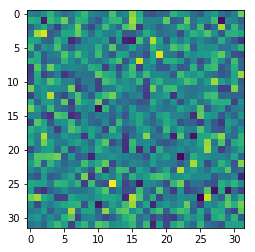

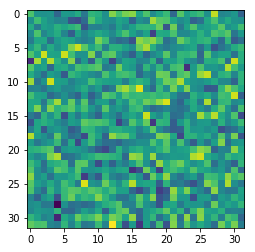

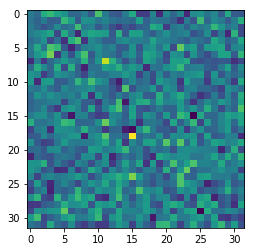

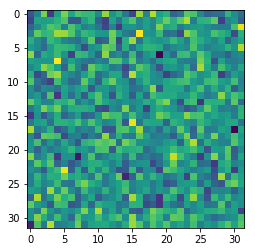

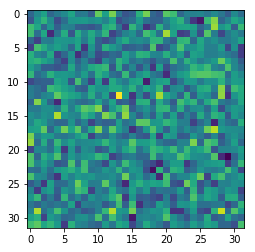

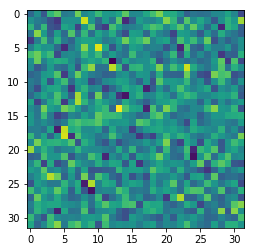

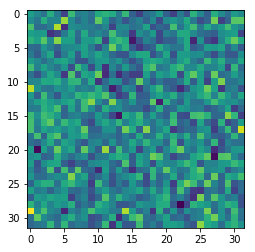

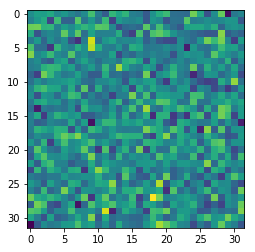

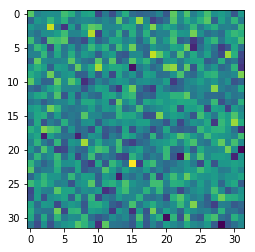

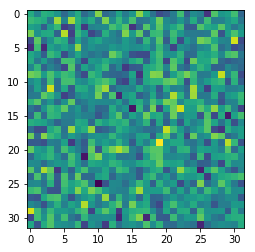

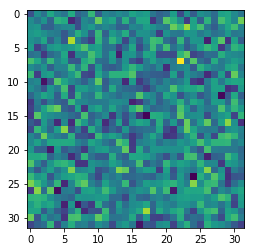

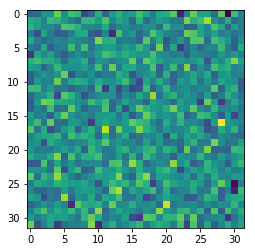

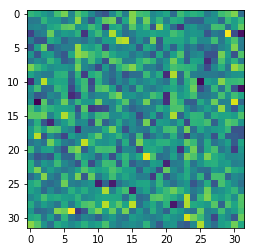

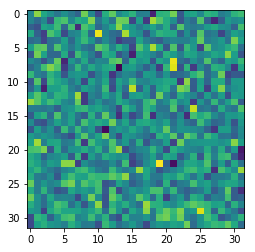

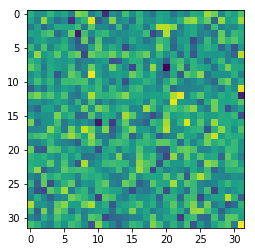

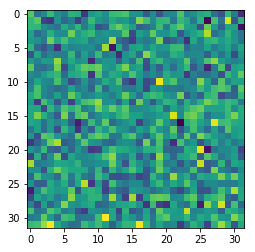

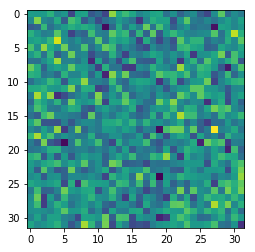

In [88]:
# visualize first 20 components
for i in range(20):
    components = data_transformed[:, i]
    vis = components.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)

In [89]:
data_transformed, reconstructed_data = run_pca(data)
norm_diff = diffsnorm(reconstructed_data, data)
print(f"norm difference between original and reconstructed data: {norm_diff}")

norm difference between original and reconstructed data: 6.020734123305333e-16


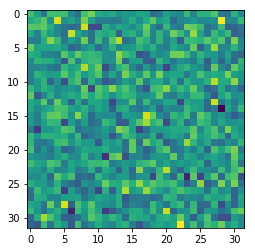

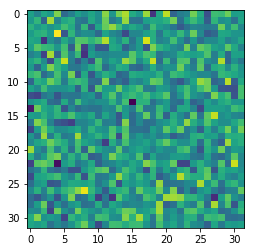

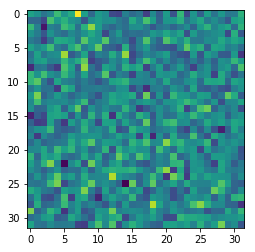

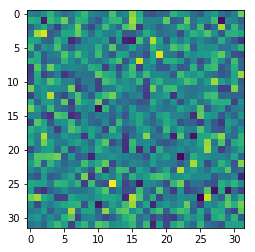

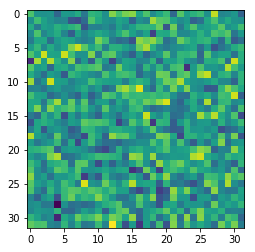

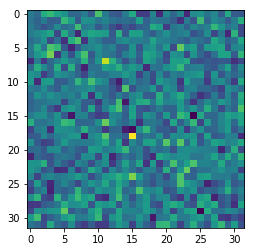

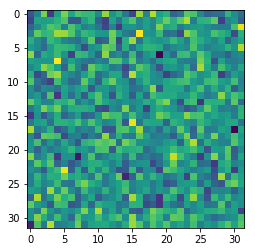

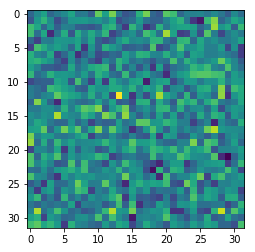

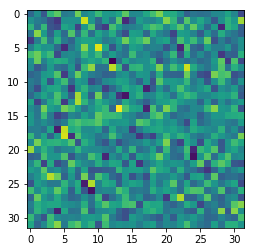

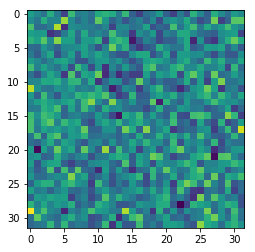

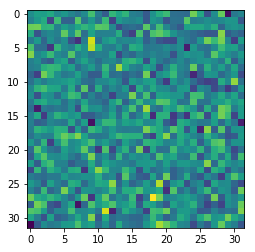

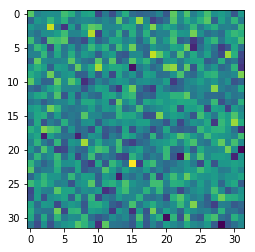

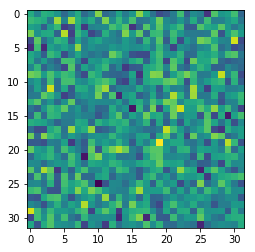

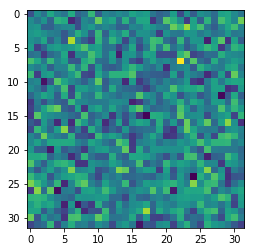

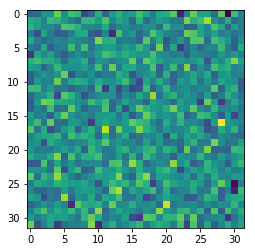

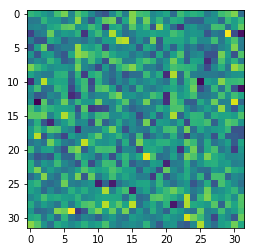

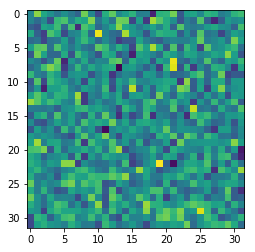

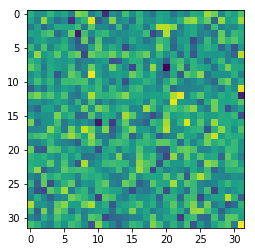

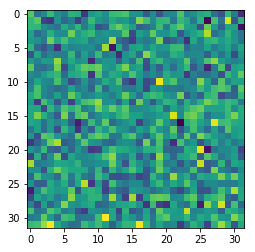

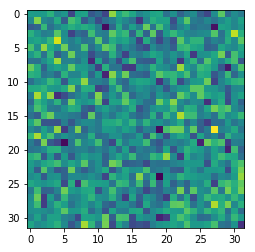

In [90]:
# visualize first 20 components
for i in range(20):
    components = data_transformed[:, i]
    vis = components.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)


# A component contained only within a single frame

In [91]:
for factor in np.arange(0.05, 1, 0.2):
    new_single = single_data.copy()
    new_single[0, :] += last_component * factor
    print("99 components")
    data_transformed, reconstructed_data = run_pca(new_single, n_components=99)
    print("100 components")
    data_transformed, reconstructed_data = run_pca(new_single, n_components=100)

99 components
100 components
99 components
100 components
99 components
100 components
99 components
100 components
99 components
100 components


In [92]:
compare_benchmark(single_data)

(4.549062083061082e-16, 9.122597794496818e-16, 1.590920860457655e-13)

In [93]:
data_transformed, reconstructed_data = run_pca(single_data)
norm_diff = diffsnorm(reconstructed_data, single_data)
print(f"norm difference between original and reconstructed data: {norm_diff}")

norm difference between original and reconstructed data: 4.549062083061082e-16


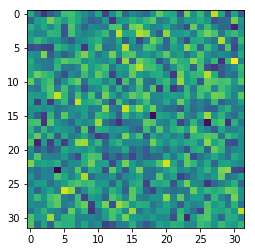

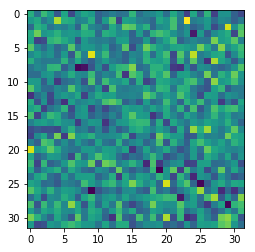

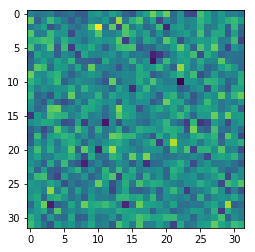

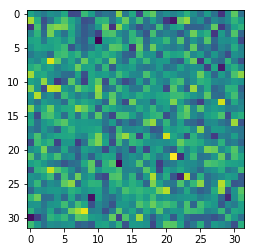

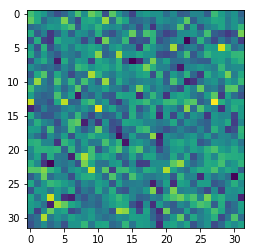

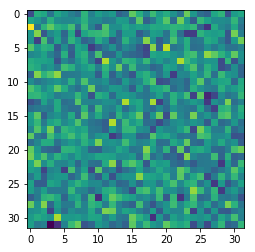

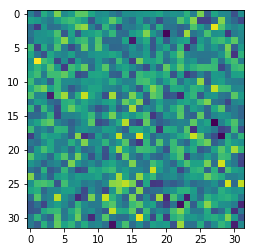

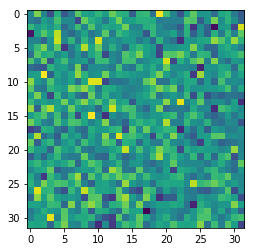

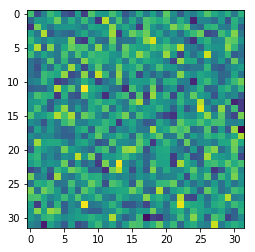

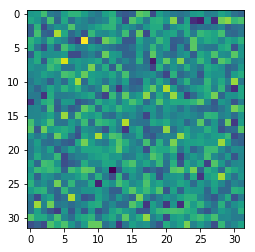

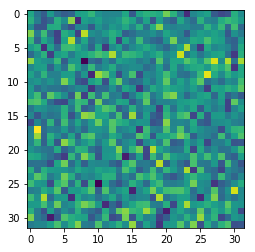

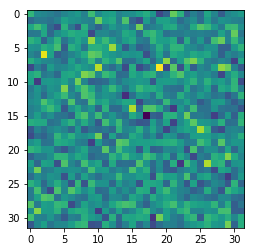

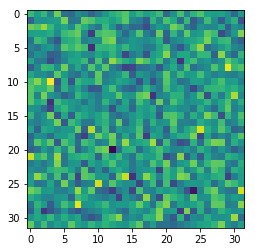

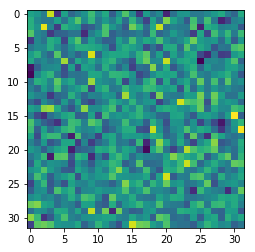

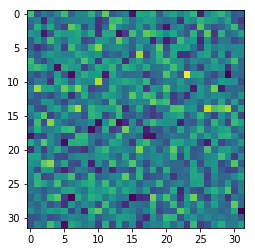

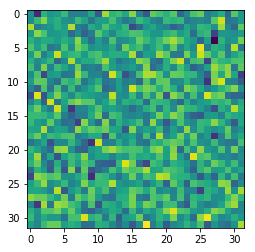

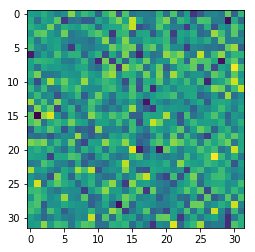

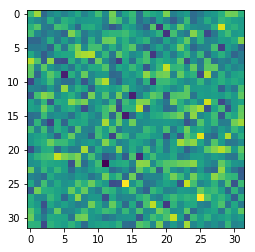

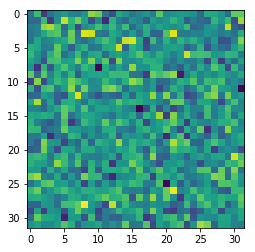

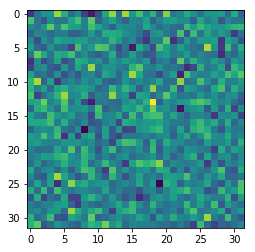

In [94]:
# visualize first 20 components
for i in range(20):
    components = data_transformed[:, i]
    vis = components.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)


In [95]:
for n_component in range(90, 110, 1):
    new_single = single_data.copy()
    new_single[0, :] += last_component * factor
    U, S, V = svd(new_single, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = ((new_single @ V.T) @ V)
    norm_diff = diffsnorm(reconstructed_data, new_single)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 90 components using full batch data: 0.055938393055750796
norm difference wih 91 components using full batch data: 0.052463767141555595
norm difference wih 92 components using full batch data: 0.04883864393629756
norm difference wih 93 components using full batch data: 0.04498764100019506
norm difference wih 94 components using full batch data: 0.04081444900753534
norm difference wih 95 components using full batch data: 0.03632186083184489
norm difference wih 96 components using full batch data: 0.03125584499571134
norm difference wih 97 components using full batch data: 0.025382008449625564
norm difference wih 98 components using full batch data: 0.017820672627239336
norm difference wih 99 components using full batch data: 0.0022046645363374548
norm difference wih 100 components using full batch data: 5.986893336974381e-16
norm difference wih 101 components using full batch data: 5.866065506066259e-16
norm difference wih 102 components using full batch data: 5.8515

# Differing intensities of component vectors

In [96]:
for j in range(-1, -100, -10):
    for n_components in range(99, 101, 1):
        scaled_data = scale_data(data, order=j)
        data_transformed, reconstructed_data = run_pca(scaled_data, n_components)
        norm_diff = diffsnorm(reconstructed_data, scaled_data)
        print(f"norm difference between original and reconstructed data using {n_components} components: {norm_diff}")
        
        reconstruct_diff, benchmark_diff, transformed_diff = compare_benchmark(scaled_data)
        print(f"reconstruct norm difference : {reconstruct_diff}, benchmark norm difference : {benchmark_diff}, transformed norm difference : {transformed_diff}")

norm difference between original and reconstructed data using 99 components: 0.01079601420286655
reconstruct norm difference : 5.326745477371148e-16, benchmark norm difference : 9.566470138853749e-16, transformed norm difference : 2.6919977481378514e-14
norm difference between original and reconstructed data using 100 components: 5.835390728471598e-16
reconstruct norm difference : 5.835390728471598e-16, benchmark norm difference : 9.811885183458334e-16, transformed norm difference : 4.3592592470488055e-14
norm difference between original and reconstructed data using 99 components: 0.0010114410885970252
reconstruct norm difference : 3.9059905898284196e-16, benchmark norm difference : 6.574553755262074e-16, transformed norm difference : 1.6067503765215007e-14
norm difference between original and reconstructed data using 100 components: 3.894780748884968e-16
reconstruct norm difference : 3.894780748884968e-16, benchmark norm difference : 8.009191626992563e-16, transformed norm difference 

# Add Gausian noise to the data

In [97]:
def find_noise_threshold(data, factor=0.01):
    norm_diff = 1
    
    while norm_diff > 1e-3:
        data_transformed, reconstructed_data = run_pca(data, 100, noise_factor=factor)
        norm_diff = diffsnorm(reconstructed_data, data)
        
        if norm_diff <= 1e-3:
            print(f"Using {factor} for factor of a normal distribution as an upper bound, the PCA works well")
            return
        
        factor /= 5

In [98]:
# single component contained in a single frame
find_noise_threshold(single_data)

Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well


In [99]:
# scale the components to check the intensity
find_noise_threshold(scaled_data)

Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well


In [100]:
# orthonormal dataset
find_noise_threshold(data)

Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well


In [101]:
compare_benchmark(data)

(6.020734123305333e-16, 9.21313341147294e-16, 2.560703965997134e-13)

In [102]:
compare_benchmark(single_data)

(4.549062083061082e-16, 8.940747929884014e-16, 1.0725300857125413e-13)

In [103]:
compare_benchmark(scaled_data)

(3.0749653332296248e-16, 4.6342863340004155e-16, 2.046296793911773e-15)

# loading drawn from heavy tail distribution

In [104]:
# Use exponential distribution
loading = np.random.exponential(scale=np.log(2), size=(1024, 100))
exp_data = loading @ component
np.random.shuffle(exp_data.T)

In [105]:
compare_benchmark(exp_data)

(7.254840641289692e-16, 1.2835463037814852e-15, 8.826706027016567e-14)

In [106]:
# Use gamma distribution
loading = np.random.gamma(0.00000005, 0.0000005, size=(1024, 100))
gamma_data = loading @ component
np.random.shuffle(gamma_data.T)

In [107]:
compare_benchmark(gamma_data)

/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:282: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)
/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:282: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)


(1.3679758751829784e-15, 5.327609965242199e-16, 1.4742541100876808e-15)

In [108]:
for i in range(16):
    perc = 1 - 1/(10^i)
    noise_frame_data = noise_frame(perc=perc)
    compare_benchmark(noise_frame_data)

ZeroDivisionError: division by zero

In [ ]:
noise_frame_data = noise_frame(perc=1)
compare_benchmark(noise_frame_data)

# Loading as identity matrix or all ones matrix

In [ ]:
loading = np.identity(1024)[:, :100]
id_data = loading @ component

In [ ]:
compare_benchmark(id_data)

In [ ]:
loading = np.ones((1024, 1024))[:, :100]
one_data = loading @ component

In [ ]:
compare_benchmark(one_data) # get error

# Compare the performance using different number of partitions

In [ ]:
n_comp = 20

loading = np.random.rand(1024, 20)
data = loading @ component[:20]
np.random.shuffle(data.T)

i = 1

while i**2 <= 16:
    data_transformed, reconstructed_data = run_pca(data, n_components=n_comp, n_part=i**2)
    norm_diff = diffsnorm(reconstructed_data, data)
    print(f"norm difference between original and reconstructed data: {norm_diff} with {i**2} number of partitions")
    
    i += 1

### The above result shows that the number of partitions does not affect the performance of the algorithm

# Collinear basis vectors

In [118]:
collinear_base = np.random.rand(1, 1024)

for _ in range(99):
    collinear_base = np.vstack((collinear_base, (collinear_base[0, :]) * (1/np.random.rand())))
loading = np.random.rand(1024, 100)
data = loading @ collinear_base
np.random.shuffle(data.T)

compare_benchmark(data, 50)

(3.037028398295903e-16, 1.8262931198078247e-16, 7.977701122255783e-16)

### The above result shows that standard PCA and the implemented PCA can equally well reduce the dimension of the matrix when the base is consisted of collinear vectors

# Differentiating the size of the data to check if there is a non-negligble time difference between the standard PCA and the implemented PCA

In [121]:
init = ortho_group.rvs(dim=2000)

In [133]:
n_component = 10
for i in range(8, 43, 2):
    n = i ** 2
    base = inits[:n_component, :n]
    loading = np.random.rand(n, n_component)
    data = loading @ base

    compare_benchmark(data, n_component, bool_time=True)
    

For the implemented PCA, it took 0.014759540557861328s. For standard PCA, it took 0.0019040107727050781s
For the implemented PCA, it took 0.011012077331542969s. For standard PCA, it took 0.004347562789916992s
For the implemented PCA, it took 0.017156600952148438s. For standard PCA, it took 0.008646011352539062s
For the implemented PCA, it took 0.01603245735168457s. For standard PCA, it took 0.011518001556396484s
For the implemented PCA, it took 0.02717733383178711s. For standard PCA, it took 0.024864912033081055s
For the implemented PCA, it took 0.03780961036682129s. For standard PCA, it took 0.03770804405212402s
For the implemented PCA, it took 0.07576251029968262s. For standard PCA, it took 0.07373189926147461s
For the implemented PCA, it took 0.09528779983520508s. For standard PCA, it took 0.12832069396972656s
For the implemented PCA, it took 0.14907431602478027s. For standard PCA, it took 0.03815174102783203s
For the implemented PCA, it took 0.2467055320739746s. For standard PCA, i

### The above result was not expected. Naturally, it is expected that the time it takes to run implemented PCA, which is a distributed version, would be shorter than that of the standard PCA. One can draw several hypotheses on this result, with the most probable one being that the prototype version implemented in this notebook is not optimized to the level it is optimized in LiberTEM. Another issue could be that the size of the data is too small for the distributed version to work better than the standard version

For the implemented PCA, it took 0.005567073822021484s. For standard PCA, it took 0.0014204978942871094s
For the implemented PCA, it took 0.00712275505065918s. For standard PCA, it took 0.0027627944946289062s
For the implemented PCA, it took 0.00993490219116211s. For standard PCA, it took 0.005417585372924805s
For the implemented PCA, it took 0.014911174774169922s. For standard PCA, it took 0.010761499404907227s
For the implemented PCA, it took 0.02623915672302246s. For standard PCA, it took 0.023579120635986328s
For the implemented PCA, it took 0.03761172294616699s. For standard PCA, it took 0.03666353225708008s
For the implemented PCA, it took 0.07658815383911133s. For standard PCA, it took 0.06538915634155273s
For the implemented PCA, it took 0.09439826011657715s. For standard PCA, it took 0.10935592651367188s
For the implemented PCA, it took 0.15856122970581055s. For standard PCA, it took 0.03879952430725098s
For the implemented PCA, it took 0.2597475051879883s. For standard PCA, i

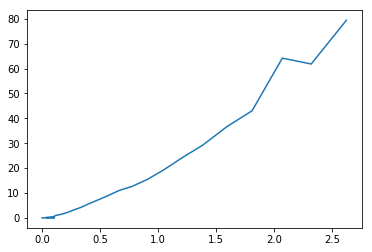

In [137]:
n_component = 10
inits = np.random.rand(5000, 5000)
new = []
orig = []

for i in range(8, 70, 2):
    n = i ** 2
    base = inits[:n_component, :n]
    loading = np.random.rand(n, n_component)
    data = loading @ base

    _, _, _, new_time, orig_time = compare_benchmark(data, n_component, bool_time=True)
    new.append(new_time)
    orig.append(orig_time)
    
plt.plot(orig, new)

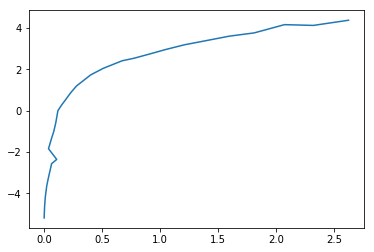

In [138]:
plt.plot(orig, np.log(new))

### We take a step further by investigating what the latency occurred in the implemented PCA. 

In [ ]:
def time_run_pca(data, n_components=100, noise_factor=None, n_part=4):
        
    sig_dim = int(math.sqrt(data.shape[0]))
    nav_dim = int(math.sqrt(data.shape[1]))
    
    assert (sig_dim ** 2) == data.shape[0]
    assert (nav_dim ** 2) == data.shape[1]
    
    new_data = data.copy()
    
    if noise_factor:
        noise = np.random.normal(0, 0.1, size=(new_data.shape[0], new_data.shape[1])) * noise_factor
        new_data += noise
    
    # reformat data into sig and nav dimension
    new_data = new_data.reshape((sig_dim, sig_dim, nav_dim, nav_dim))
    
    start_part = time.time()
    
    partition = process_partition(new_data, n_components, n_part)
    
    end_part = time.time()
    
    start_merge = time.time()
    
    data_transformed, reconstructed_data = merge(new_data, partition, n_components)
    
    end_merge = time.time()
    
    print(f"processing partition took {end_part - start_part}s, merging the partitions took {end_merge - start_merge}s")
       
    return data_transformed, reconstructed_data, start_merge, end_merge

processing partition took 0.0009548664093017578s, merging the partitions took 0.004472970962524414s
processing partition took 0.0015780925750732422s, merging the partitions took 0.005516529083251953s
processing partition took 0.0018885135650634766s, merging the partitions took 0.007781505584716797s
processing partition took 0.0033736228942871094s, merging the partitions took 0.011257171630859375s
processing partition took 0.005899906158447266s, merging the partitions took 0.019359588623046875s
processing partition took 0.009462356567382812s, merging the partitions took 0.02899169921875s
processing partition took 0.015848159790039062s, merging the partitions took 0.0432438850402832s
processing partition took 0.026746034622192383s, merging the partitions took 0.06647562980651855s
processing partition took 0.04726672172546387s, merging the partitions took 0.10309004783630371s
processing partition took 0.05736064910888672s, merging the partitions took 0.18220949172973633s
processing partit

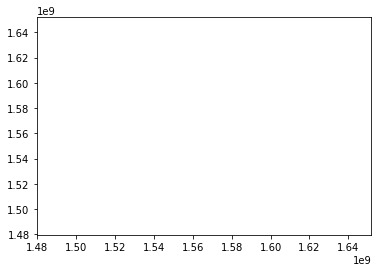

In [30]:
n_component = 10
inits = np.random.rand(5000, 5000)
new = []
orig = []

for i in range(8, 50, 2):
    n = i ** 2
    base = inits[:n_component, :n]
    loading = np.random.rand(n, n_component)
    data = loading @ base

    _, _, part_time, merge_time = time_run_pca(data, n_component)
    new.append(part_time)
    orig.append(merge_time)
    
plt.plot(new, orig)

### From the above result, it appears that merging phase takes most of the time taken. Note that merging phase utilizes the standard IPCA library (Incremental PCA) and perform partial fit on each of the partitions, whereas the standard PCA method performs fit on the full batch data at once. Then the question boils down to, how big should the data matrix be for Incremental PCA method to have advantage over standard full batch PCA?

For the implemented PCA, it took 0.007437229156494141s. For standard PCA, it took 0.0026748180389404297s
For the implemented PCA, it took 0.060541629791259766s. For standard PCA, it took 0.08887076377868652s
For the implemented PCA, it took 0.6849119663238525s. For standard PCA, it took 0.13724064826965332s
For the implemented PCA, it took 3.6575114727020264s. For standard PCA, it took 0.290938138961792s
For the implemented PCA, it took 12.450152158737183s. For standard PCA, it took 0.7857084274291992s
For the implemented PCA, it took 40.27008676528931s. For standard PCA, it took 1.694782018661499s
For the implemented PCA, it took 94.47787356376648s. For standard PCA, it took 3.1325361728668213s
For the implemented PCA, it took 213.91873574256897s. For standard PCA, it took 5.229938745498657s
For the implemented PCA, it took 440.0407350063324s. For standard PCA, it took 8.52221393585205s


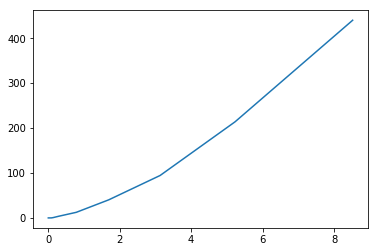

In [32]:
n_component = 10
inits = np.random.rand(10000, 10000)
new = []
orig = []

for i in range(10, 100, 10):
    n = i ** 2
    base = inits[:n_component, :n]
    loading = np.random.rand(n, n_component)
    data = loading @ base

    _, _, _, new_time, orig_time = compare_benchmark(data, n_component, bool_time=True)
    new.append(new_time)
    orig.append(orig_time)
    
plt.plot(orig, new)

Text(0, 0.5, 'implemented PCA')

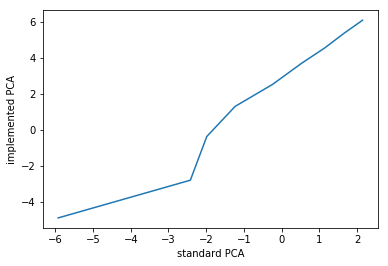

In [40]:
plt.plot(np.log(orig), np.log(new))
plt.xlabel("standard PCA")
plt.ylabel("implemented PCA")

### Unfortunately, it takes too long to compute once the matrix has more than 1e9 entries so it was not possible to verify when the implemented PCA outperforms the standard PCA, if ever. Another hypothesis is that it is simply incorrect to compare the performance of the implemented PCA with the standard PCA. IPCA, which is used in this prototype version of the implemented PCA, was originally designed not necessarily to improve the speed of the PCA algorithm, but to deal with a very large matrix in which the standard PCA could not fit the full data. Thus, the standard PCA algorithm would always outperform the implemented PCA, until the data becomes too big.

# Bimodal distribution (exploit the hyperbox property)

In [ ]:
import random
def bimodal(low1, high1, mode1, low2, high2, mode2, shape):
    """
    generate loading based on bimodal distribution
    """
    mat = np.zeros(shape)
    nrow = shape[0]; ncol = shape[1]
    
    for i in range(nrow):
        for j in range(ncol):
            toss = random.choice((1, 2))
            
            if toss == 1:
                mat[i, j] = random.triangular(low1, high1, mode1)
            else:
                mat[i, j] = random.triangular(low2, high2, mode2)
                
    return mat
    

In [ ]:
loading = bimodal(-10, -9, -1, 8, 10, 9, (1024, 100))

In [ ]:
bimodal_data = loading @ component

In [ ]:
compare_benchmark(bimodal_data)

# Another case to test the volatility of hyperbox method (Create a customized data)

In [53]:
# choose an outlier randomly by the specified proportion of the data
def outlier(mat, perc=0.005):
    
    """
    Given a data matrix, assign the specified percentage number of entries
    to be outliers (push to the extreme of either positive or negative direction)
    """
    nrow, ncol = mat.shape
    
    n = int(perc * nrow * ncol)
    
    for _ in range(n):
        i = np.random.randint(0, nrow)
        j = np.random.randint(0, ncol)
        
        mat[i, j] *= 1e9 * np.random.choice([-1, 1])
    
    return mat

In [54]:
loading = np.random.normal(0, 1e-5, size=(1024, 100))

loading = outlier(loading)
data = loading @ component

compare_benchmark(data)
    

(8.538280720905154e-16, 1.6627019461186768e-15, 1.4689216123350732e-13)

In [65]:
def sdev(nrow, ncol):
    """
    Generate a matrix of samples that have different standard deviations by
    adjusting the value of loading matrix
    """
    for row in range(1, nrow+1):
        
        new_sample = np.random.normal(0, (row**2)*1e-8, size=(1, ncol))
        
        if row == 1:
            loading = new_sample

        else:
    
            loading = np.vstack((loading, new_sample))
        
    np.random.shuffle(loading)
    
    return loading

In [67]:
loading = sdev(1024, 100)
data = loading @ component
compare_benchmark(data)

(1.0305977177101262e-15, 1.7717885875096846e-15, 4.9587991630829973e-14)